Notebook Linear Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data: de target is beter doen dan r² = 80% nauwkeurigheid die in de meeste uitwerkingen zit...
- Ook door andere vormen van regressie toe te passen, het doel is om r² zo goed mogelijk te krijgen

==> Resultaat: r² = 86% en 27% fout marge 


Extra:
- er wordt logging voorzien voor en na de belangrijke stappen (zie LinReg_logging.log). Hiermee kunnen de stappen en de resultaten opgevolgd worden. Dit wordt in de LinReg_logging weg geschreven
- we hebben een aantal herbruikbare code-blokken in een functie gestoken
- een aparte class gemaakt voor BinaryValueEncoders om eens te proberen (kan uiteraard met de OneHotEncoder)
- we hebben een functie geschreven om snel een reeks van modellen te kunnen evalueren, zowel zonder pipelining als met pipelining

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/mirichoi0218/insurance/data

Metadata :
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- data summarizen via summarytools 
- missing en duplicated data oplossen 
- incorrect types controleren
- numerische waarde standardizeren
- categorische varaiabelen processen
- feature engineering checken
- linear, ridge, lasso, gradient boost, random forest,...  modellen uitvoeren
- alle modellen toegepast op 2 situaties voor stratefy
    - Train_test_split zonder stratify
    - Train_test_split met stratefy op basis van de categorisatie van de charges (target v) (omdat er skewness is op charges )

- zowel met pipelining als zonder pipelining uitgewerkt
- voor het beste model (XGSBoost) gaan we nog een Hyperparameter tuning uitvoeren





In [37]:
# import van de diverse modules
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# Machine learning algorithm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error



# system utils
import warnings
from pathlib import Path
import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet

Extra code snippits die doorheen de notebook gebruikt worden:

save_fig: na generatie van een image kan de image naar file geschreven worden in de images/.. directory. Geef steeds een zinvolle naam

read_JSON: om eenvoudig een JSON in te lezen

log_info:
- logging functie om doorheen de notebooks de status naar file te kunnen schrijven. 
- de logstatements worden tijdens de uitvoering van de code bewaard in een list. Die kan tussentijds naar het scherm geprint worden of naar een file
- log_info_write_to_file: schrijf de loginformatie naar file 
- log_info_print_on_screen: print alle loginfo naar het scherm

In [38]:
# enkele extra code snippets gebruikt doorheen de oefening

# to plot or not to plot - zet op True om de plots te zien, zet op False om de plots niet te zien bij een Run ALL
plot_graphs = True



# schrijf een visual naar file

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Lezen van de JSON-file

def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json


# functies om te loggen naar file
log_info_lijst = []

log_filenaam = "LinReg_continue.log"
if os.path.exists(log_filenaam):
    os.remove(log_filenaam)

def log(log_code="INFO", boodschap="euh geen boodschap????"):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : {log_code} : {boodschap}"
    log_info_lijst.append(log_message)
    with open(log_filenaam, 'a') as file:  # Open the file in append mode
        file.write(str(boodschap) + '\n')  # Voeg een nieuwe regel toe na elke string
    print(log_message)
    return

def log_info(boodschap):
    log("Info",boodschap)
    def log_info_write_to_file(filename):
        with open(filename, 'a') as file:  # Open the file in append mode
            for string in log_info_lijst:
                file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
        return

def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return

def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return

Code snippets om visuals op het scherm te plaatsen
Deze worden doorheen de notebook gebruikt

In [39]:
# functie: maakt een boxplot van kolommen in een pandaframe
# df_col is een list van de kolomnamen die geplot worden

def plot_boxplot(df, df_col, filenaam):
    if plot_graphs:
        # boxplot van de numerische waarden
        sns.set_theme(style="whitegrid", palette="bright")
        plt.figure(figsize=(15, 10)) 
        for i, col in enumerate(df_col):
            plt.subplot(len(df_col), 2, 2 * i + 1)
            sns.boxplot(x=df[col], orient='h', linewidth=1.5)
            plt.title(f"Boxplot of {col}", fontsize=12, fontweight="bold")
            plt.xlabel(col, fontsize=10)

            plt.subplot(len(df_col), 2, 2 * i + 2)
            sns.histplot(df[col], kde=True,  linewidth=1)
            plt.title(f"Distribution Plot of {col}", fontsize=12, fontweight="bold")
            plt.xlabel(col, fontsize=10)
            plt.ylabel("Density", fontsize=10)

        plt.tight_layout()
        save_fig(filenaam)
        plt.show()

Hulpfuncties

bereken_percentage_outliers: via Isolation forest wordt het percentage van de outliers berekend.
- df : dataframe
- columns_to_use: list van koloms die gebruikt worden om de outliers te berekenen
- functie geeft een percentage terug van het aaantal outliers op het totaal aantal observaties


cap_values: vervang outliers door hun lower of upperpercentieel waarde: de whiskers worden berekend door van de lower_percentieel waarde een waarde af te trekken gelijk aan 1,5 * IQR (interquartile range), voor upper_percentieel waarde wordt de 1,5 * IQR bijgeteld
- df: dataframe
- columns_to_use
- lower_percentieel (default = 25)
- upper_percentieel (default = 75)


BinaryValueEncoder: hulp klasse om categorische te classificeren naar 0 en 1
- string_zero: indien categorische waarde = string_zero, krijgt de nieuwe waarde 0
- string_one: indien categorische waarde = string_zero, krijgt de nieuwe waarde 1
Try-out om zelf eens een class te schrijven voor transformation. Kan uiteraard ook via OneHotEncoding gedaan worden


In [40]:
# functie om het percentage outliers te berkenen voor een set van kolommen in een dataframe
def bereken_percentage_aantal_outliers(df , columns_to_use):
    # Initialiseren van het Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Fit het model
    iso_forest.fit(df[columns_to_use])
    # Voorspellingen
    # Het geeft -1 voor outliers en 1 voor inliers
    labels = iso_forest.predict(df[columns_to_use])
    # Toevoegen van de labels aan het DataFrame om outliers te identificeren
    df_intern = df.copy()
    df_intern['outlier'] = labels
    outliers = df_intern[df_intern['outlier'] == -1]
    aantal_outliers = df_intern['outlier'].value_counts()
    print(aantal_outliers)
    percentage_aantal_outliers = (len(outliers) / len(df_intern)) * 100

    return percentage_aantal_outliers


# functie om outliers in een kolom te cappen op een percentiel waarde
def cap_values(df_input, column, lower_percentile=25, upper_percentile=75):
    # voeg code toe om beter de outliers te verwijderen
    log("Info", f"Capping values voor kolom {column} naar lower percentiel {lower_percentile} - upper percentiel {upper_percentile}")
    q1, q3 = np.percentile(df_input[column], [lower_percentile, upper_percentile])  # Calculate the 25th (Q1) and 75th (Q3) percentiles
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower whisker (Q1 - 1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr  # Calculate upper whisker (Q3 + 1.5 * IQR)

    # lower_bound = df[column].quantile(lower_percentile)
    # upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df_output = df_input.copy()
    df_output[column] = np.where(df_input[column] < lower_bound, lower_bound, df_input[column])
    df_output[column] = np.where(df_input[column] > upper_bound, upper_bound, df_input[column])    
    return df_output


# hulp klasse om categorische waarden met twee mogelijke waarde naar 0 en 1 om te zetten
# was een try-out om zelf eens een encoder te schrijven
# kan uiteraard eenvoudiger door OneHotEncoding toe te passen, we hebben dan ook OneHotEncoding toegepast 

class BinaryValueEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, string_zero="nul", string_one="een"):
        # Je kunt hier extra initialisatie toevoegen indien nodig
        self.string_zero = string_zero
        self.string_one = string_one
     

    def fit(self, X, y=None):
        # Er is geen fitting nodig voor deze eenvoudige codering
        return self

    def transform(self, X):
        # X wordt aangenomen een pandas DataFrame te zijn
        log("Info", f"BinaryValueEncoder transform opgeroepen voor One_value {self.string_one} en Zero_value {self.string_zero}")
        X = X.copy()  # Kopieer de DataFrame om wijzigingen te voorkomen in het origineel
        X = X.applymap(lambda x: 1 if x == self.string_zero else 0)
        return X
    
    def get_feature_names_out(self, input_features=None):
        # Dit is een eenvoudige passthrough-voorbeeld, waarbij feature namen niet wijzigen.
        if input_features is not None:
            return input_features
        else:
            return np.array(['x{}'.format(i) for i in range(X.shape[1])], dtype=object)



Hier beginnen we er echt met het inlezen van de data en de eerste checks op de data

In [41]:
# data bestand inlezen

insurance_data_filename = 'data/insurance.csv'
df = pd.read_csv(insurance_data_filename)
log_info(f"File ingelezen: {insurance_data_filename}")

# check op duplicates, indien zo verwijder direct
df.drop_duplicates(inplace=True)
df_original = df.copy()
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates na drop \n{duplicate_waarden}")

# behoudt een copie van de orginele data
df_original = df.copy()

14/02/2025 13:24:56 : Info : File ingelezen: data/insurance.csv
14/02/2025 13:24:56 : Info : Check op duplicates na drop 
0


In [42]:
# enkele eenvoudige controles
log_info(f"df.info : \n{df.info()}")
log_info(f"df.describe : \n{df.describe()}")

# geen nulwaarden 

from summarytools import dfSummary
dfSummary(df)

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB
14/02/2025 13:24:56 : Info : df.info : 
None
14/02/2025 13:24:56 : Info : df.describe : 
               age          bmi     children       charges
count  1337.000000  1337.000000  1337.000000   1337.000000
mean     39.222139    30.663452     1.095737  13279.121487
std      14.044333     6.100468     1.205571  12110.359656
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.290000     0.000000   4746.344000
50%      39.000000    30.400000     1.0000

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 39.2 (14.0)min < med < max:18.0 < 39.0 < 64.0IQR (CV) : 24.0 (2.8),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACXklEQVR4nO3cT27aQBiH4W9KCOaPbCEk2HGBSl2w9CF62B4hC07ADdghIQTCiYUx7qJCaSsVYruOfzbvs43GQaOXAY8YuyzLDFDxpe4XAPzu6dYfnXN9M3sueO1TlmVvBcfiQf0zSOdcfzKZfPd9f1zkwofDYeec+0GUyOPWCvns+/44DMO3IAjiPBfd7/fecrkcb7fbZzMjSHzYzY9sM7MgCOLpdPpa4Nr9AmPw4LipgRSChBSChBSChBSChBSChBSChBSChBSChBSChBSChBSChBSChBSChBSChBSChBSChJS7vxhH9ThM966yINM07ZqZ75wrMrxVk3wLh+n+VEmQURR1kyT5Np/PO51OJ9cBMbNmTnKJVc4fjUbTMAwPHKarKMjT6fTked5gsVjEs9lsl2dsEye5zCqXJImXpunXXq/3wmG6ir9DDofDRzmxWPjI8Hq9Hq9Wq8H5fO5U9eKapHU3NXXeIBQ5Mrzb7Wp78yneTLUqSG4QPk51rloVpPG0jTwk56ptQZoZT9vIQ22uWhnkIymx3+tfLpduDf/X7Mb3T8kg65rkpimz33vdborj+MXMcq2QVe4zywVZ1yQ3UZn93jLbTVXuM8sFWdckmzV3ZS6y3/s/tpuq2GeWC/LqsyeZlVmDbJCfrc6VGe8I8i91ffzhF36gCykECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSl3HxSw3++9vBc9Ho+emVkURd5msxkwlrFX93r6Cb5xtK2GD1U3AAAAAElFTkSuQmCC"">",0(0.0%)
2,sex[object],1. male2. female,675 (50.5%)662 (49.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
3,bmi[float64],Mean (sd) : 30.7 (6.1)min < med < max:16.0 < 30.4 < 53.1IQR (CV) : 8.4 (5.0),548 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACV0lEQVR4nO3bwYraQBzH8f/UdYkKEbHozRco9ODRh+jD9hEq+AS+gTchSMTUYIzpoQvtFnaXjJPmt9nv5z6YwxfDZP7jqqoyQMWnth8A+NtD2w8QmnNuYGaPnssvVVWdQz4P6ulUkM65wXQ6/RbH8cRn/fF4PDjnvhNlezoVpJk9xnE8Wa1W5/F4nNdZmKZptNlsJkmSPJoZQbaka0Gamdl4PM5ns9lPj6WD4A+DWtjUQApBQkonX9m+yrLsm1nsnPNZzg49AIJ8kmVZvyiKr4vFotfr9WptiMzYoYdCkE8ul8tDFEXD5XKZz+fzQ5217NDDIch/jEYjdugtYlMDKQQJKQQJKQQJKQQJKQQJKZKffe6YaYxvt1s/9PPg/5EL8p6ZxqIoorIsv+R5/sPMfL4lomVyQdodM4273W6y3W6H1+u119TDoVmKQZqZ30zj4XDgtOSdY1MDKQQJKQQJKQQJKbKbmveGafMwCDIAps3DIcgAmDYPhyADYtr8fmxqIIUgIYUgIYUgIYUgIYUgIYUgIYUgIYUgIaWxkxouasFHI0FyUQu+mvqH5KIWvDQ6XMFFLdTFpgZSCBJSmIcUwPWHPwiyZVx/eI4gW8b1h+cIUgTXH35jUwMpBAkpBAkpBAkpBAkpBAkpBAkpBAkpr34YZ+pbX9fOwV8MkqlvfV08B3/tH5Kpb3FdPAd/8yybqW99vufgZVnGJva6Z7jig1J93RPkB3Xv6369Xs+SJPnsnDv6/PxLIb8ZZJqmUd1fO51OkZlZlmXRfr8fslZ3rY/z+dzYv+svSFme8aj5M/MAAAAASUVORK5CYII="">",0(0.0%)
4,children[int64],1. 02. 13. 24. 35. 46. 5,573 (42.9%)324 (24.2%)240 (18.0%)157 (11.7%)25 (1.9%)18 (1.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACw0lEQVR4nO3dQU7bUBiF0T9RRJuJowiJZbCALKKL7SKygOwDRXjQUCbpoJTSDoCBfZ9lnzNj9pA+vciRr7K6Xq8FCevWB2A5xEaM2IgRGzGrqtpW1U3rg0zA8/V6vbQ+xJxtbm9vv3Vdt299kNb6vj+vVqvvghvPpuu6/eFwuOx2u6fWh2nl8fHx6/F43D88PNxUldhGsqmq2u12T3d3dz9aH6axbesDzJ0HBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlP1+xWb1gdpaen/f8qm7/vz8Xjc18Jfsen7/lxVz63PMWdeC//La+EjWxkpkzLlm81NMzOTHbwYoMzPJAcvBijzNOXBy6KfjufIl7rEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiJnkumpq52EYk11XWTvNjw0CMdZVxLS42dxYCxVfV1lNLVd0XWU1tWwt1lWTeuolx5e6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IiJrqusppYtvq6ymlouGwRirKuIGfJmc2PxrsHWVVZTfGSQdZXVFJ8x

In [43]:
# drie categorische features: smoking, region en sex
# vier numerische features waaronder de target variabele "charges"
# maak de datasets aan 

df_cat_col = ['smoker','region','sex']
df_num_col = ['age', 'bmi','children']
df_label_col = ['charges']

# zijn er nominaal categorische variabelen en één ordinal categorische waarden?
df_cat_nom_col = ['smoker','region']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]

In [44]:
# korte analyze van de categorische variabelen
print(df_cat.value_counts())

# check op nullen
nul_waarden = df.isnull().sum()
log_info(f"Check op nulwaarden \n{nul_waarden}")
# geen nullen

smoker  region     sex   
no      southwest  female    141
        southeast  female    139
        northwest  female    135
        southeast  male      134
        northeast  female    132
        northwest  male      131
        southwest  male      126
        northeast  male      125
yes     southeast  male       55
        northeast  male       38
        southwest  male       37
        southeast  female     36
        northwest  male       29
                   female     29
        northeast  female     29
        southwest  female     21
Name: count, dtype: int64
14/02/2025 13:24:56 : Info : Check op nulwaarden 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


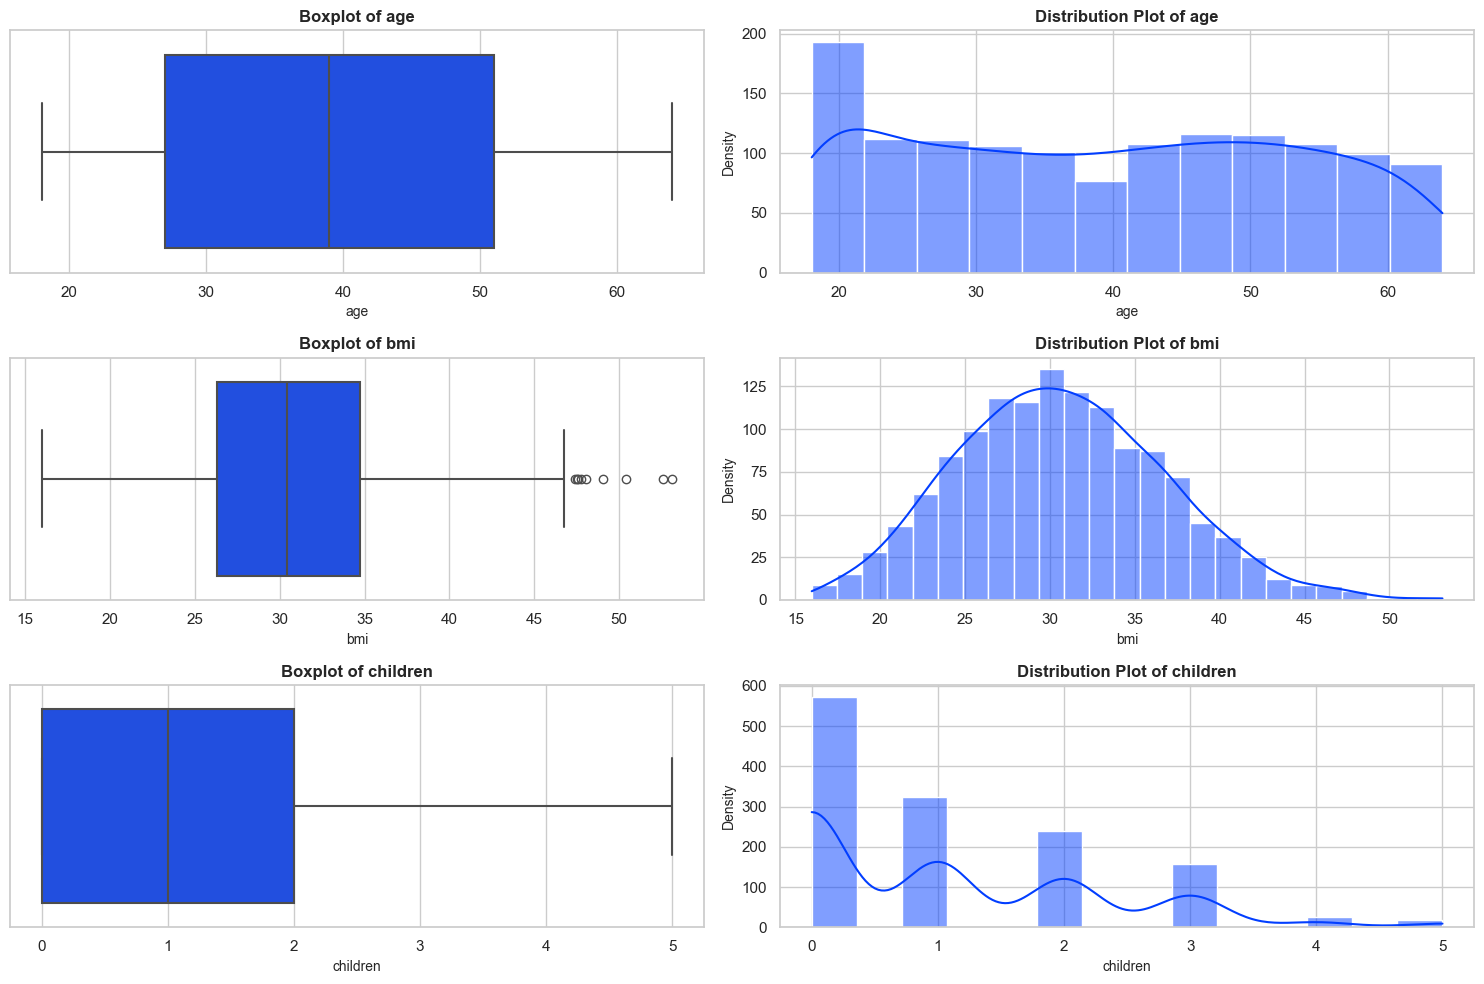

In [45]:
plot_boxplot(df, df_num_col,"Boxplot en histogram van de numerische waarden")

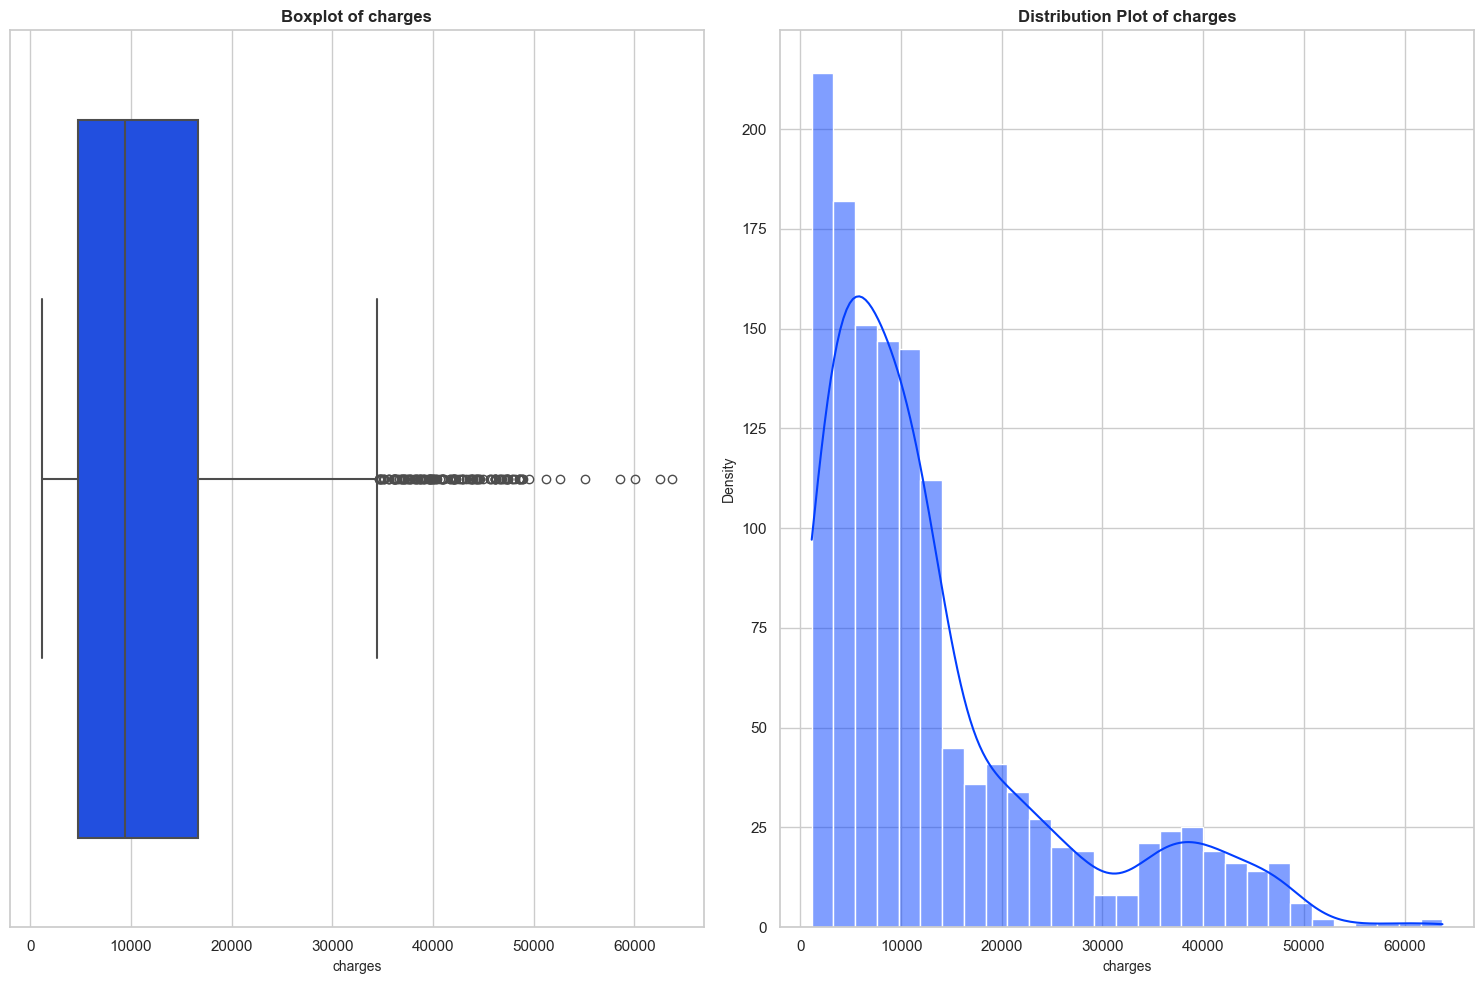

In [46]:
plot_boxplot(df, df_label_col,"Boxplot en histogram van de target value")

# we zien hier dat er enkele outliers zijn in de kolom charges
# we gaan hier rekening mee houden


C:\Users\geert\AppData\Local\Temp\ipykernel_30556\339065784.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_30556\339065784.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_30556\339065784.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')


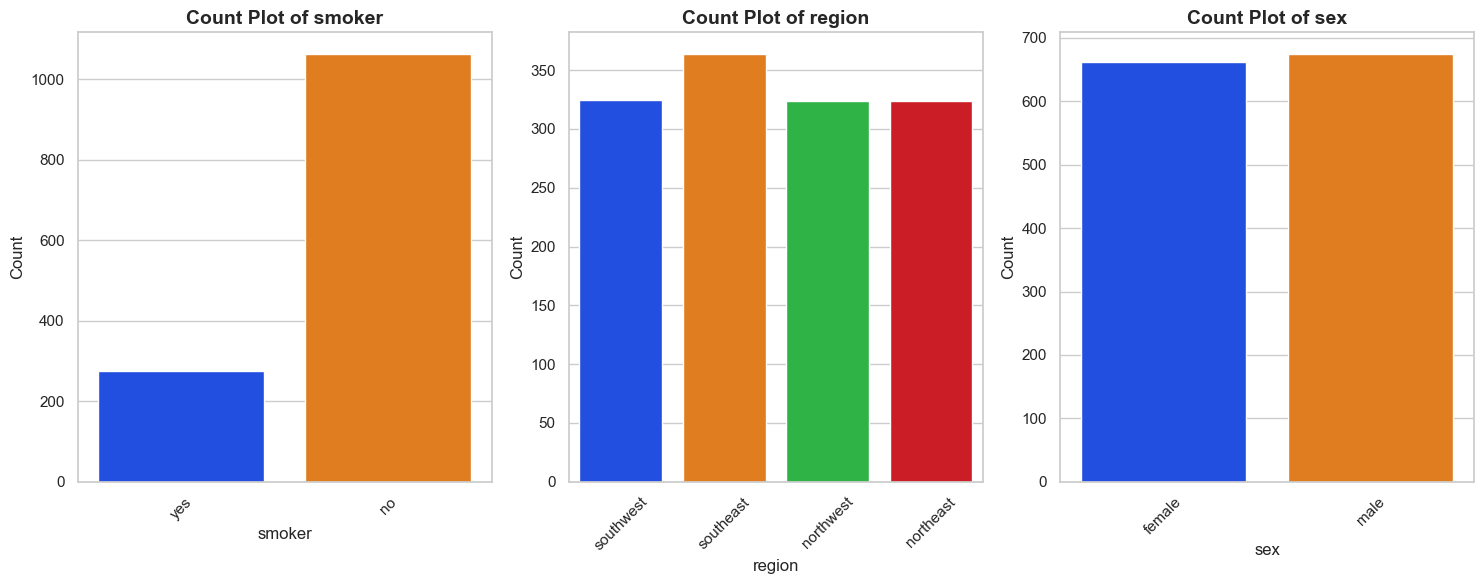

14/02/2025 13:24:59 : Info : Check van categorische features


In [47]:
if plot_graphs:
    sns.set_theme(style="whitegrid", palette="bright")
    plt.figure(figsize=(15, len(df_cat_col) * 2))  

    for i, col in enumerate(df_cat_col):
        plt.subplot(1, len(df_cat_col), i + 1)
        sns.countplot(x=col, data=df, palette='bright')
        plt.title(f"Count Plot of {col}", fontsize=14, fontweight="bold")
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)

    plt.tight_layout()
    save_fig("Categorische features countplot")
    plt.show()
    log_info("Check van categorische features")

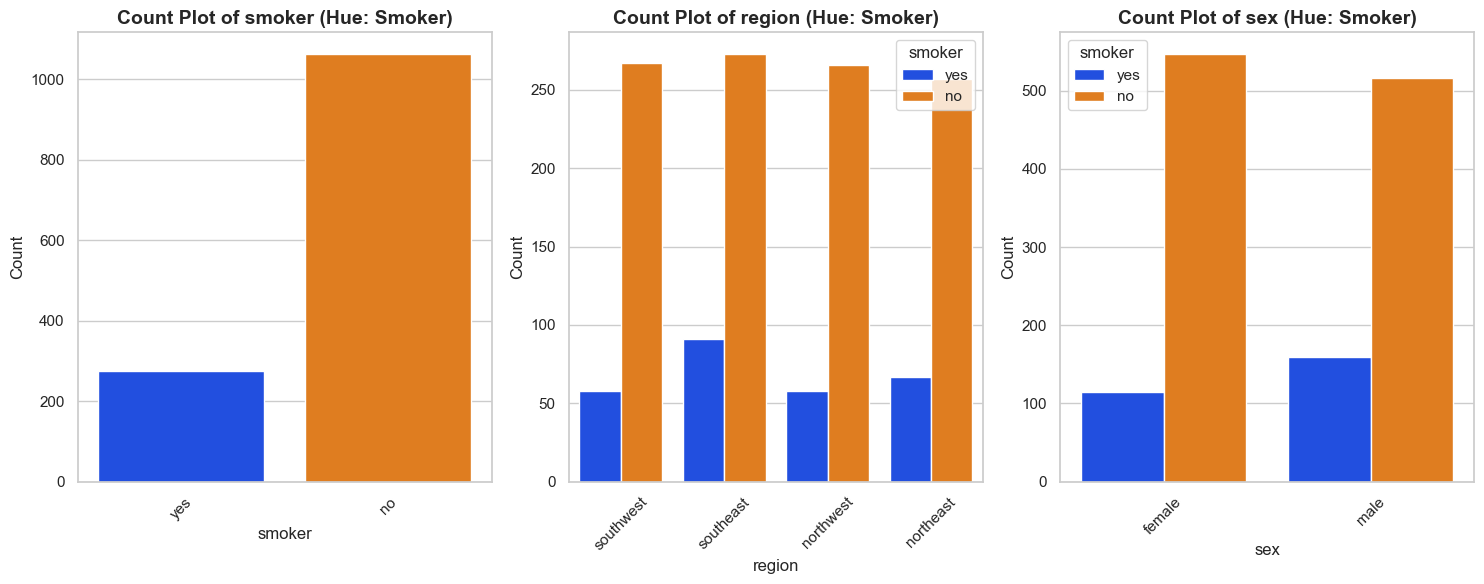

In [48]:
if plot_graphs:
    sns.set_theme(style="whitegrid", palette="bright")
    plt.figure(figsize=(15, len(df_cat_col) * 2))  

    for i, col in enumerate(df_cat_col):
        plt.subplot(1, len(df_cat_col), i + 1)
        sns.countplot(x=col, data=df, palette='bright', hue='smoker')
        plt.title(f"Count Plot of {col} (Hue: Smoker)", fontsize=14, fontweight="bold")
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)

    plt.tight_layout()
    save_fig("Categorische variabelen tov smoker")
    plt.show()

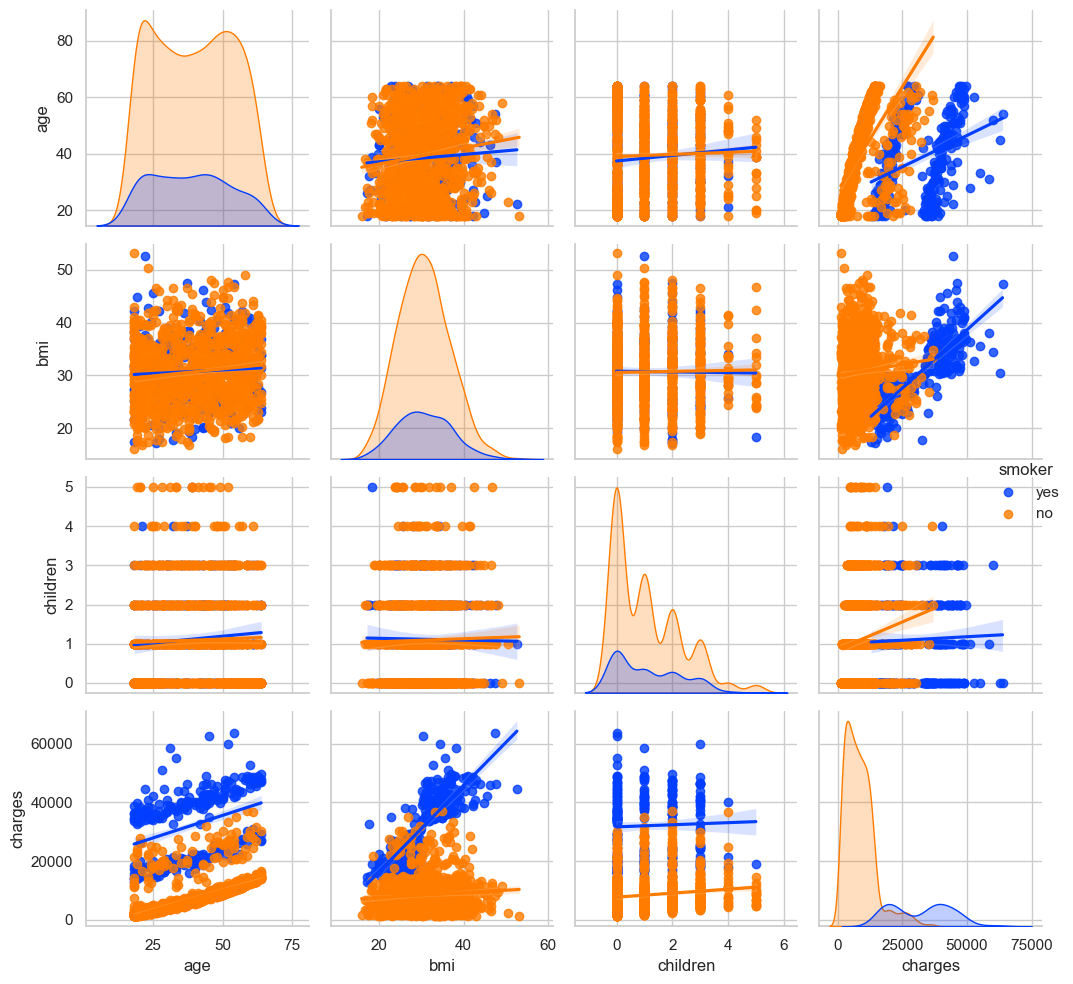

In [49]:
if plot_graphs:
    sns.pairplot(df, hue='smoker',  kind='reg')
    plt.tight_layout()
    save_fig("Numerische features onderlinge scatter")
    plt.show()

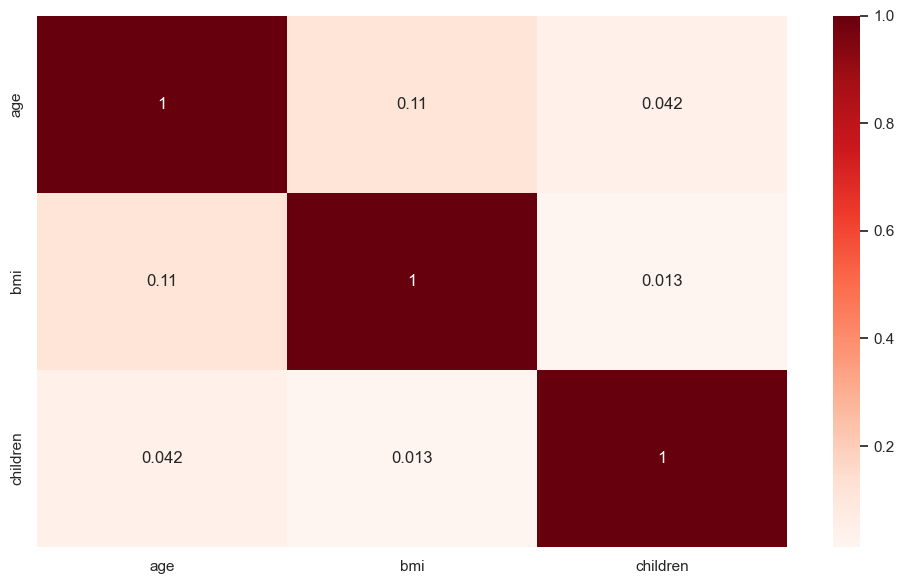

C:\Users\geert\AppData\Local\Temp\ipykernel_30556\3933097125.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Dataset['sex'] = Dataset['sex'].replace(['male','female'],[0,1])
C:\Users\geert\AppData\Local\Temp\ipykernel_30556\3933097125.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Dataset['smoker'] = Dataset['smoker'].replace(['yes','no'],[1,0])
C:\Users\geert\AppData\Local\Temp\ipykernel_30556\3933097125.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To re

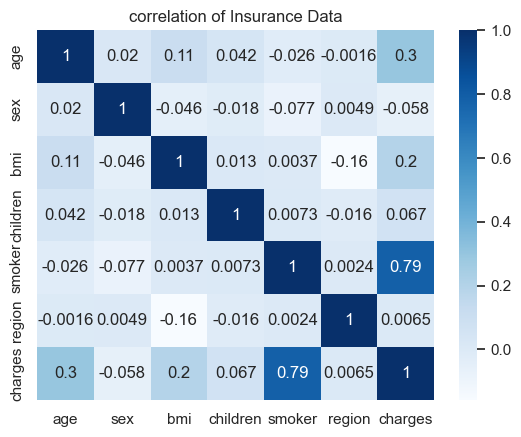

In [50]:
# print de correlation nog af tussen de numerische waarden

if plot_graphs:
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid", palette="bright")
    sns.heatmap(df[df_num_col].corr(), annot=True, cmap='Reds')
    save_fig("Numerische features correlatie")
    plt.show()


Dataset = df.copy()
Dataset['sex'] = Dataset['sex'].replace(['male','female'],[0,1])
Dataset['smoker'] = Dataset['smoker'].replace(['yes','no'],[1,0])
Dataset['region'] = Dataset['region'].replace(['southwest','southeast','northwest','northeast'],[0,1,2,3])

sns.heatmap(Dataset.corr(),annot=True,cmap='Blues')
plt.title('correlation of Insurance Data')
plt.show()


# enkel tussen smoker en charges is er een duidelijke correlatie

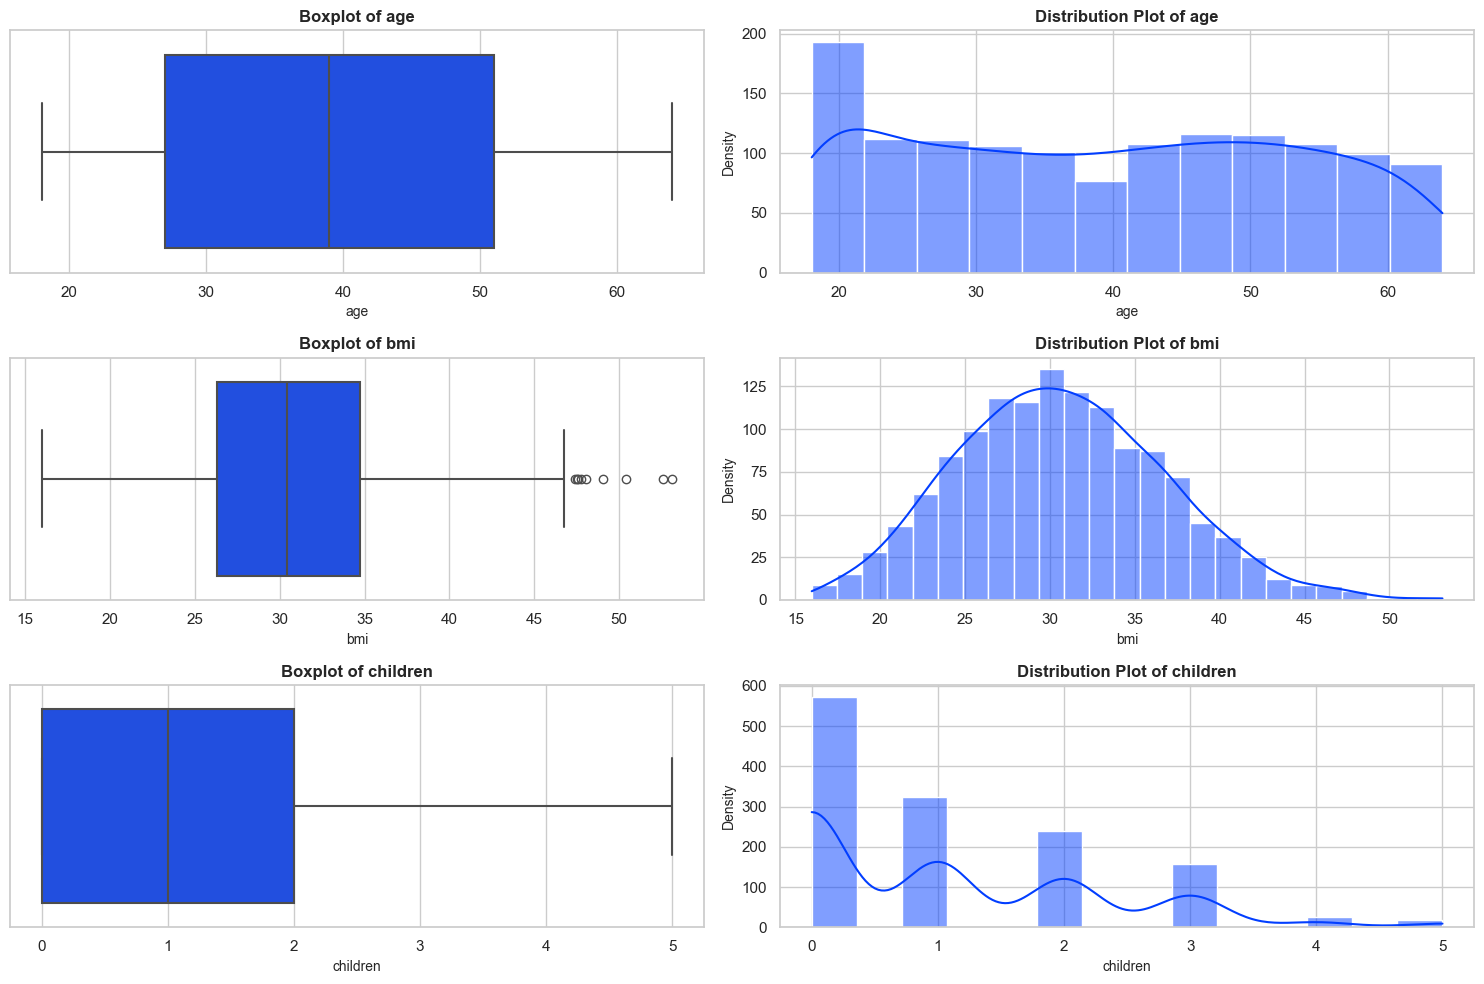

outlier
 1    1074
-1     263
Name: count, dtype: int64
19.670905011219148
14/02/2025 13:25:07 : Info : Check op de outliers in kolom ['bmi'] : 19.670905011219148
14/02/2025 13:25:07 : Info : Capping values voor kolom bmi naar lower percentiel 25 - upper percentiel 75
outlier
 1    1030
-1     307
Name: count, dtype: int64
22.961854899027674
14/02/2025 13:25:07 : Info : Check op de outliers in kolom [bmi, charges] na capping op kolom [bmi]  : 22.961854899027674
14/02/2025 13:25:07 : Info : Capping wordt niet toegepast op de dataset


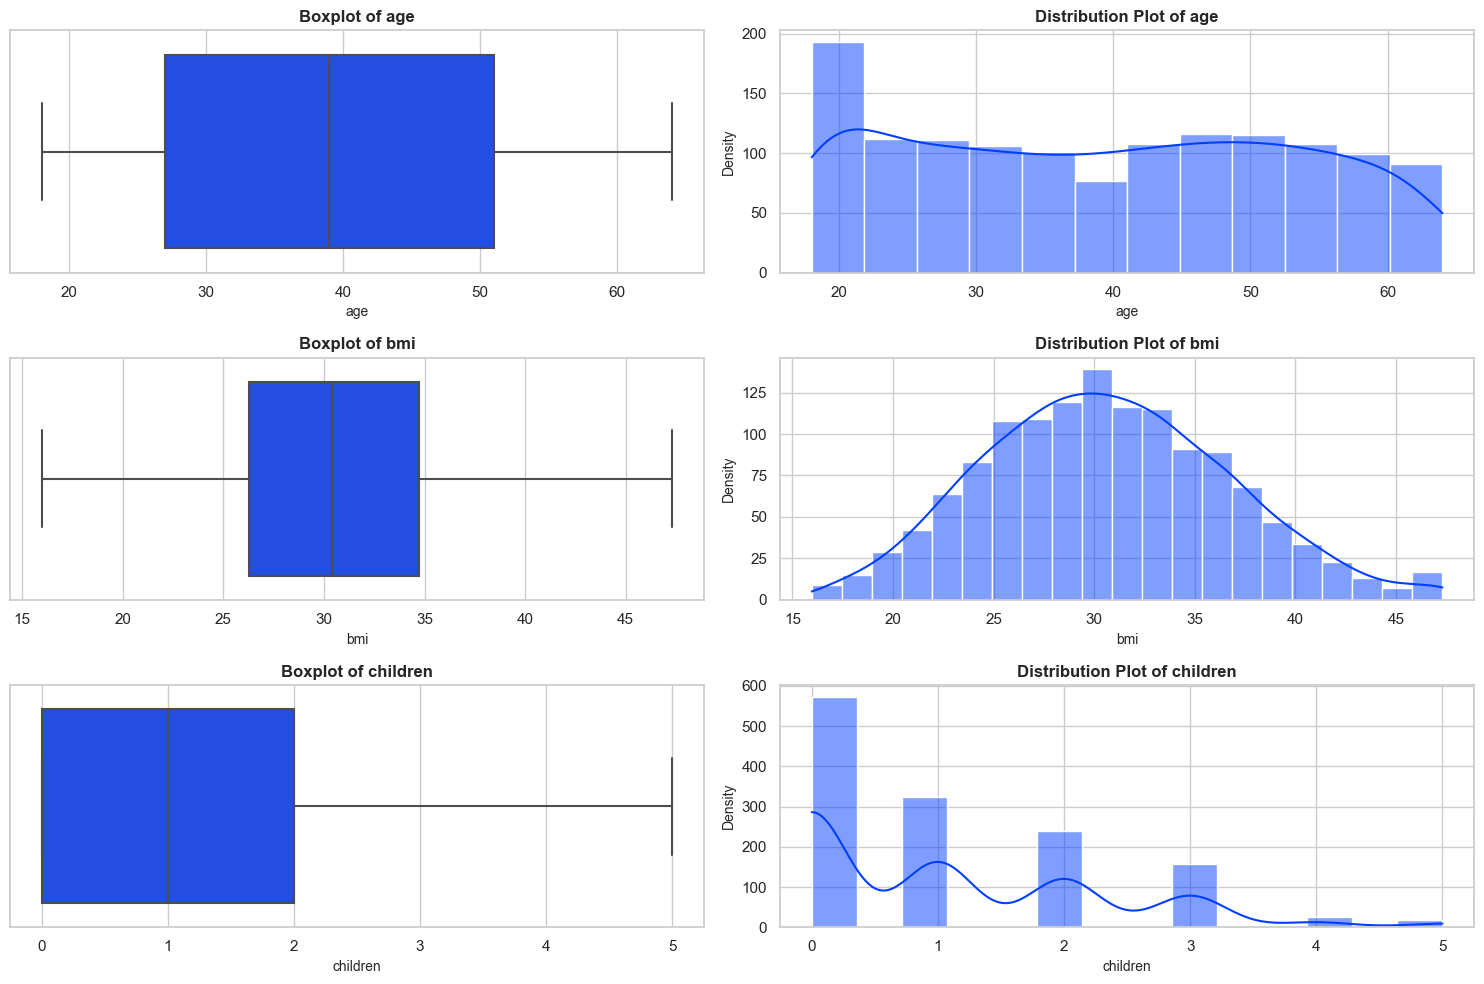

In [51]:
def verwijder_outliers(df_input, df_input_col):
    # Bereken de outliers
    percentage_aantal_outliers = bereken_percentage_aantal_outliers(df_input, df_input_col)
    print(percentage_aantal_outliers)
    log_info(f"Check op de outliers in kolom {df_input_col} : {percentage_aantal_outliers}")

    df_output = df_input.copy()
    for col in df_input_col:
        df_output = cap_values(df_output, col)    

    percentage_aantal_outliers = bereken_percentage_aantal_outliers(df_output, df_input_col)
    print(percentage_aantal_outliers)
    # plot_boxplot(df, df_num_col,"Boxplot en histogram na removing van de outliers")
    log_info(f"Check op de outliers in kolom [bmi, charges] na capping op kolom [bmi]  : {percentage_aantal_outliers}")
    log_info("Capping wordt niet toegepast op de dataset")

    return df_output

plot_boxplot(df_original, df_num_col,"Boxplot en histogram na removing van de outliers")
df_zonder_outliers = verwijder_outliers(df_original,['bmi'])
plot_boxplot(df_zonder_outliers, df_num_col,"Boxplot en histogram na removing van de outliers")




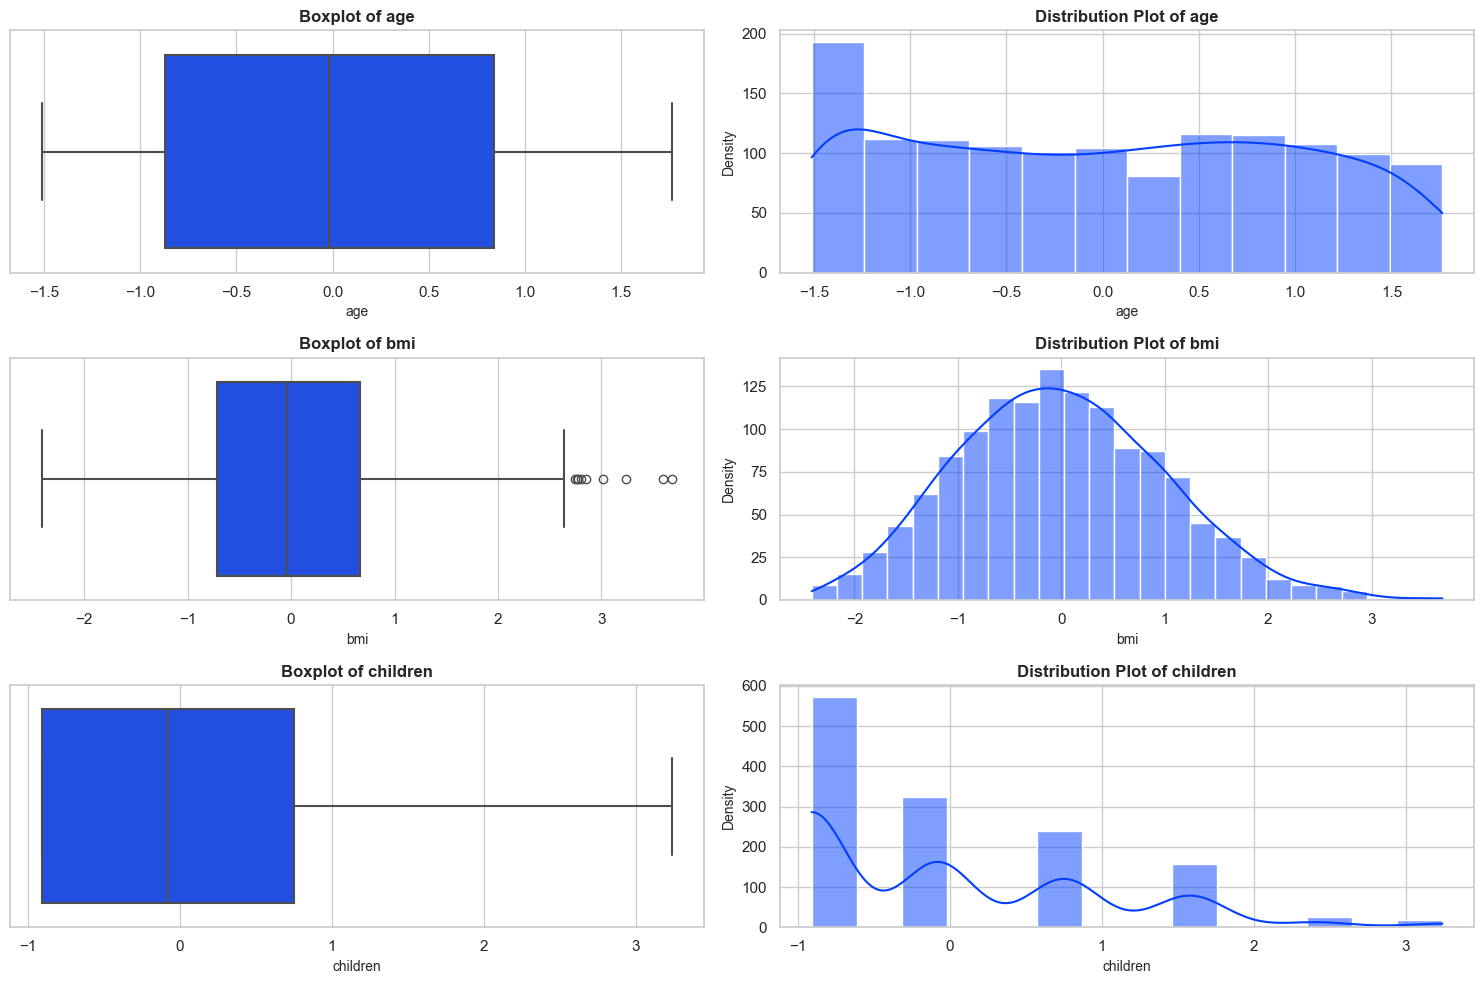

In [52]:
# Feature preparation
# standard scaler op de numerische waarden, min-max scaler

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

#set_matplotlib_closeV_encoder = BinaryValueEncoder("male","female")
#set_matplotlib_smoking_encoder = BinaryValueEncoder("yes","no")
# bv_encoder = PredefinedBinaryCategoricalEncoder(positive_class='female')

male_female_transformer = Pipeline(steps=[
     #('male_female_encoder', BinaryValueEncoder("male","female"))
    ('male_female_encoder', OneHotEncoder(drop='first'))
])

smoking_transformer = Pipeline(steps=[
    #('smoking_encoder', BinaryValueEncoder("yes","no"))
    ('smoking_encoder', OneHotEncoder(drop='first'))
])

regio_transformer = Pipeline(steps=[
    ('regio', OneHotEncoder(drop='first', handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, df_num_col),
    ("male_female", male_female_transformer, ['sex']), 
    ("smoker", smoking_transformer, ['smoker']), 
    ("regio", regio_transformer, ['region'])],
     remainder='passthrough')

df_features = df_original.drop(['charges'], axis= 1)
np_prepared =  preprocessor.fit_transform(df_features)

# really hacking !!! get_feature_names werkt nog niet correct !!! not used now
df_prepared_col = ['age', 'bmi','children','sex','smoker','northeast','northwest','southeast','southwest']

df_prepared = pd.DataFrame(
    np_prepared,
    #columns=preprocessing.get_feature_names_out(),
    columns = [name.split('__')[-1] for name in preprocessing.get_feature_names_out()],
    #columns = df_prepared_col,
    index=df_original.index)

df_prepared.head()

plot_boxplot(df_prepared,df_num_col,"Boxplot van numerische waarden na standard scaling")




In [53]:
def excute_regression_models_with_pipeline(X_train, X_test, y_train,y_test,preprocessor):

    best_XGB_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
    
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(alpha=0.1),
        'Ridge': Ridge(alpha=0.01),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42), 
        'Decision Tree': DecisionTreeRegressor(random_state=42), 
        'XGBRegressor': XGBRegressor(random_state=42, **best_XGB_params)
    }

    results = []
    for name, model in models.items():        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures(degree=1, include_bias=False)),
            ('regressor', model)
        ])

        pipeline
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_r2 = r2_score(y_test, y_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_pred)

        results.append([name, test_rmse, test_r2, test_mape])
    df = pd.DataFrame(results, columns=['model', 'test_rmse', 'test_r2', 'test_mape'])

    return df


In [54]:
X = df_original.drop(['charges'], axis=1).copy()
y = df_original['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resultaat_eenvoudig = excute_regression_models_with_pipeline(X_train, X_test, y_train, y_test, preprocessor)
print(resultaat_eenvoudig)
log_info("")
log_info("Regression models with no stratefy")
log_info(resultaat_eenvoudig)
log_info("")

               model    test_rmse   test_r2  test_mape
0  Linear Regression  5956.342894  0.806929   0.413968
1              Lasso  5956.469554  0.806920   0.413981
2              Ridge  5956.496377  0.806919   0.413992
3      Random Forest  4729.965694  0.878249   0.392427
4  Gradient Boosting  4268.283018  0.900856   0.315065
5      Decision Tree  5912.108673  0.809786   0.388309
6       XGBRegressor  4244.328234  0.901966   0.302994
14/02/2025 13:25:19 : Info : 
14/02/2025 13:25:19 : Info : Regression models with no stratefy
14/02/2025 13:25:19 : Info :                model    test_rmse   test_r2  test_mape
0  Linear Regression  5956.342894  0.806929   0.413968
1              Lasso  5956.469554  0.806920   0.413981
2              Ridge  5956.496377  0.806919   0.413992
3      Random Forest  4729.965694  0.878249   0.392427
4  Gradient Boosting  4268.283018  0.900856   0.315065
5      Decision Tree  5912.108673  0.809786   0.388309
6       XGBRegressor  4244.328234  0.901966   0.3029

In [ ]:
# eenvoudige lineaire regressie zonder stratefy

X = df_original.drop(['charges'], axis=1)
y = df_original['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
resultaat_eenvoudig = excute_regression_models_with_pipeline(X_train, X_test, y_train, y_test, preprocessing)

print(resultaat_eenvoudig)
log_info("")
log_info("\n\nRegression models with polynomial features, no stratefy\n")
log_info("*************************************************************")
log_info(resultaat_eenvoudig)
log_info("")


In [ ]:
X = df_original.drop(['charges'], axis=1)
y = df_original['charges']

y_bins = pd.cut(y, bins=[0, 20000,30000, np.inf], labels=[1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
resultaat_eenvoudig = excute_regression_models_with_pipeline(X_train, X_test, y_train, y_test, preprocessing)

print(resultaat_eenvoudig)
log_info("")
log_info("\n\nRegression models with polynomial features, met stratefy\n")
log_info("Stratify on charges_cat: extra feature engineering: charges omzetten naar categories : bins=[0, 20000, 30000, np.inf")
log_info("Regression models polynomial features en stratify on charges_cat")
log_info(resultaat_eenvoudig)
log_info("")

In [ ]:
# hyper parameter tuning voor XGSBoost

df_features = df_original.drop(['charges'], axis= 1)
np_prepared =  preprocessing.fit_transform(df_features)

# really hacking !!! get_feature_names werkt nog niet correct !!! not used now
df_prepared_col = ['age', 'bmi','children','sex','smoker','northeast','northwest','southeast','southwest']

df_prepared = pd.DataFrame(
    np_prepared,
    #columns=preprocessing.get_feature_names_out(),
    columns = [name.split('__')[-1] for name in preprocessing.get_feature_names_out()],
    #columns = df_prepared_col,
    index=df_original.index)

df_prepared.head()


X = df_prepared
y = df_original['charges']

df = df_original.copy()
df["charges_cat"] = pd.cut(df["charges"], bins=[0, 20000,30000, np.inf], labels=[1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df["charges_cat"] , test_size=0.2, random_state=42)

xgb_model = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

# GridSearchCV opzetten
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X, y)

# Beste parameters en beste score printen
print("Beste parameters:", grid_search.best_params_)
print("Beste score:", -grid_search.best_score_)  # converteer negatieve MSE terug naar positieve waarde






In [ ]:
log_info_write_to_file("LinReg_logging.log")